# 1. Overview

# 2. Forecasting

## 2.1 Import Libraries

In [1]:
# pip install prophet

In [2]:
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global variables

In [3]:
input_data = 'data/weekly_data.csv'

## 2.3 Functions

## 2.4 Code

In [4]:
weekly_data = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data['Date'] = pd.to_datetime(weekly_data['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data = weekly_data.asfreq('W')

weekly_data.head()

,Close
Date,
2008-01-13,18.566454
2008-01-20,17.363014
2008-01-27,18.406004
2008-02-03,18.506292
2008-02-10,16.774668


### 2.4.1 Train test split

In [5]:
train_data = weekly_data[:-8]
train_data

,Close
Date,
2008-01-13,18.566454
2008-01-20,17.363014
2008-01-27,18.406004
2008-02-03,18.506292
2008-02-10,16.774668
...,...
2024-07-28,886.747009
2024-08-04,860.239990
2024-08-11,860.549988


In [6]:
test_data = weekly_data[-8:]
test_data

,Close
Date,
2024-09-01,889.880005
2024-09-08,795.599976
2024-09-15,800.169983
2024-09-22,795.280029
2024-09-29,841.539978
2024-10-06,833.000000
2024-10-13,840.690002
2024-10-20,723.260010


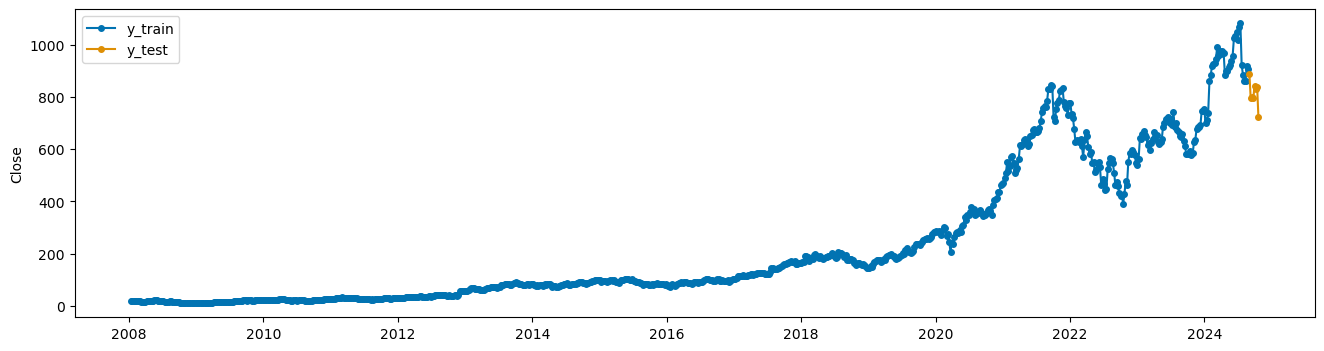

In [7]:
plot_series(train_data, test_data, labels=["y_train", "y_test"]);

### 2.4.2 Naive forecaster

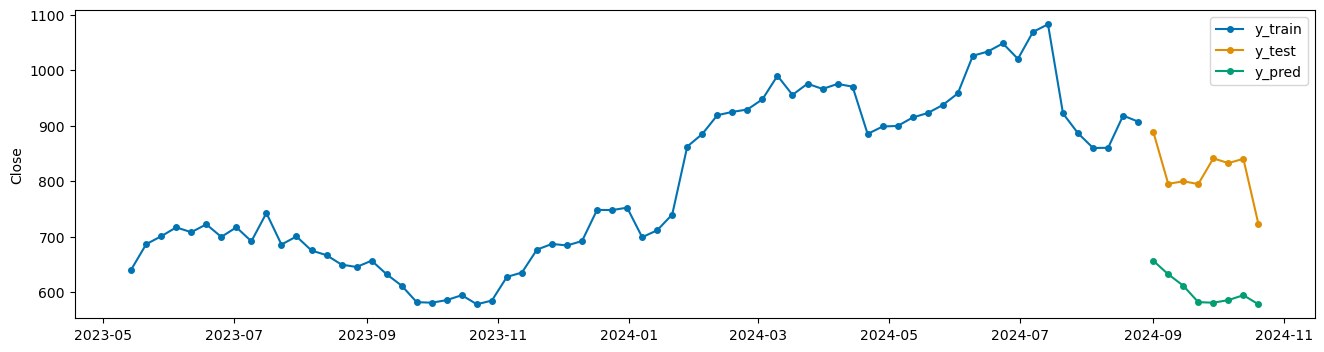

In [8]:
# Initialize the Naive Forecaster (strategy = 'last' means it will use the last value)
naive_forecaster = NaiveForecaster(strategy="last", sp=52)

# Fit the model to the training data
naive_forecaster.fit(train_data)

# Make predictions on the test set
y_pred_naive = naive_forecaster.predict(fh=[i+1 for i in range(len(test_data))])

# Plot the training, test data, and predictions
plot_series(train_data[800:], test_data, y_pred_naive, labels=["y_train", "y_test", "y_pred"]);


Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [9]:
mape_naive = mean_absolute_percentage_error(test_data, y_pred_naive) * 100
mape_naive

25.848649851869464

In [10]:
rmse_naive = root_mean_squared_error(test_data, y_pred_naive)
rmse_naive

215.54616671452865

### 2.4.3 ETS 

Initialize the ETS model with additive trend and seasonality 'seasonal_periods' should be set based on the periodicity of the data

In [11]:
ets_model_add = ExponentialSmoothing(
    train_data, 
    trend='add',          # Can also use 'mul' for multiplicative trend
    seasonal='add',       # Can also use 'mul' for multiplicative seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

Fit the model to the training data

In [12]:
fitted_model_add = ets_model_add.fit()

Generate predictions for the test set

In [13]:
y_pred_ets_add = fitted_model_add.forecast(len(test_data))

Plot the training, test data, and predictions

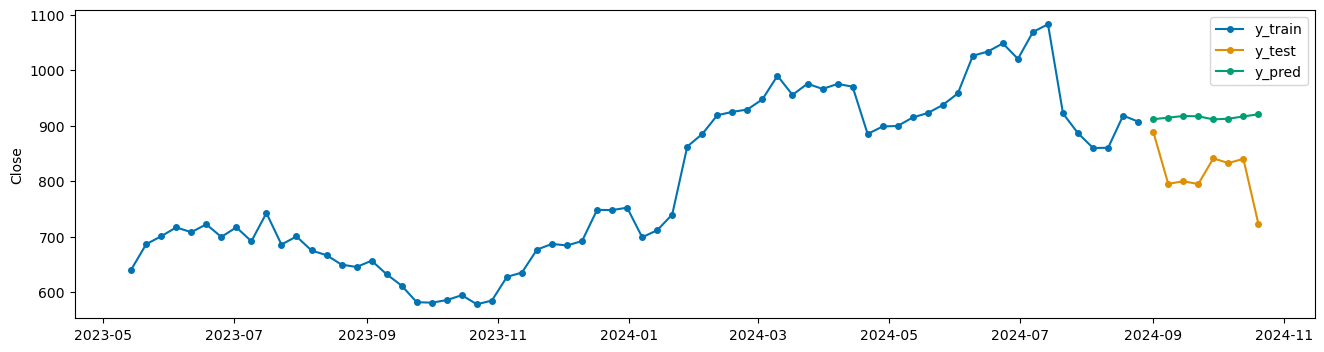

In [14]:
plot_series(train_data[800:], test_data, y_pred_ets_add, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [15]:
mape_ets_add = mean_absolute_percentage_error(test_data, y_pred_ets_add) * 100
mape_ets_add

12.74252774206973

In [16]:
rmse_ets_add = root_mean_squared_error(test_data, y_pred_ets_add)
rmse_ets_add

111.67676519011717

We are going to retry the ETS model but now we are going to modify the trend and seasonality to be multiplicative

In [17]:
ets_model_mul = ExponentialSmoothing(
    train_data, 
    trend='mul',          # Can also use 'add' for additive trend
    seasonal='mul',       # Can also use 'add' for additive seasonality
    seasonal_periods=52   # Adjust based on the seasonality of your data (e.g., 52 for weekly data)
)

Fit the model to the training data

In [18]:
fitted_model_mul = ets_model_mul.fit()

Generate predictions for the test set

In [19]:
y_pred_ets_mul = fitted_model_mul.forecast(len(test_data))

Plot the training, test data, and predictions

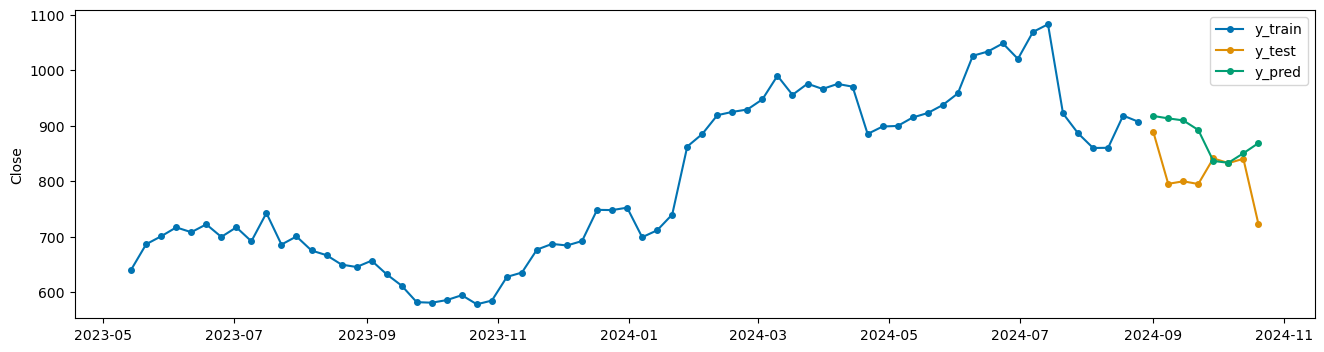

In [20]:
plot_series(train_data[800:], test_data, y_pred_ets_mul, labels=["y_train", "y_test", "y_pred"]);

Now we are going to calculate the metrics of the model. The RMSE and the MAPE

In [21]:
mape_ets_mul = mean_absolute_percentage_error(test_data, y_pred_ets_mul) * 100
mape_ets_mul

8.240655573676824

In [22]:
rmse_ets_mul = root_mean_squared_error(test_data, y_pred_ets_mul)
rmse_ets_mul

84.86783947161085

### 2.4.4 Prophet

Initialize the Prophet model

In [23]:
prophet_model = Prophet()

Fit the model to the data

First we need to modify the column names as is required by prophet

In [24]:
train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close':'y'})
train_data_prophet

,ds,y
0,2008-01-13,18.566454
1,2008-01-20,17.363014
2,2008-01-27,18.406004
3,2008-02-03,18.506292
4,2008-02-10,16.774668
...,...,...
863,2024-07-28,886.747009
864,2024-08-04,860.239990
865,2024-08-11,860.549988
866,2024-08-18,918.659973


In [25]:
prophet_model.fit(train_data_prophet)

10:55:08 - cmdstanpy - INFO - Chain [1] start processing
10:55:08 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Define the forecast horizon (e.g., 8 periods into the future)
future = prophet_model.make_future_dataframe(periods=8, freq='W')

# Generate predictions
forecast = prophet_model.predict(future)

# Going back to the train_data format
forecast = forecast[['ds','yhat']].set_index('ds').rename(columns={'yhat':'Close'})[-8:]

forecast

,Close
ds,
2024-09-01,848.326314
2024-09-08,847.430601
2024-09-15,846.606692
2024-09-22,845.529807
2024-09-29,843.526798
2024-10-06,840.973125
2024-10-13,839.843324
2024-10-20,842.349462


Plot the forecast results

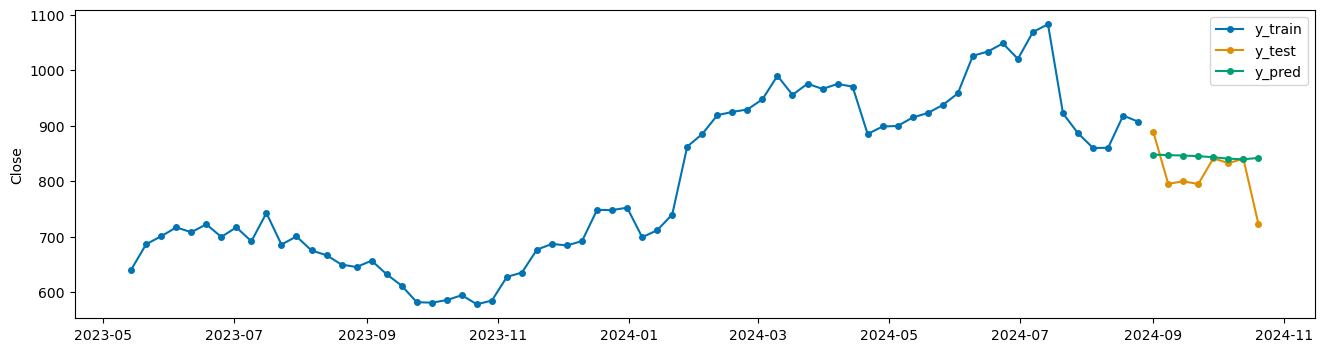

In [34]:
plot_series(train_data[800:], test_data, forecast, labels=["y_train", "y_test", "y_pred"]);

Plot forecast components (trend, weekly, yearly components)

KeyError: 'ds'

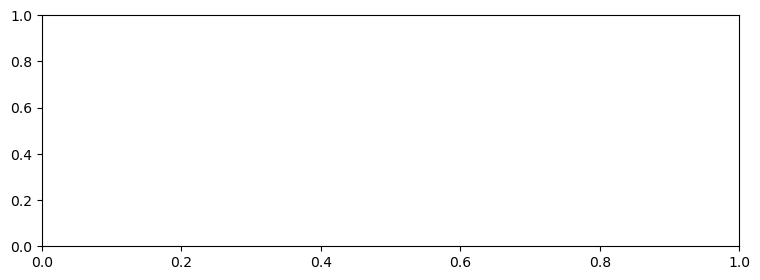

In [28]:
fig2 = prophet_model.plot_components(forecast)
plt.show()